In [1]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from keras.models import save_model
import keras
from keras.datasets import cifar10
from keras.models import load_model
from keras.callbacks import TensorBoard

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Reshape, Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, InputLayer
from keras import regularizers
from keras.callbacks import LearningRateScheduler

%matplotlib inline

Using TensorFlow backend.


In [45]:
bit_size = 1024
architecture = '1024'
autoencoder_id='03'
model_path = F'models/bitsize{bit_size}/{architecture}architecture/'

In [46]:
class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))


# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)

In [47]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [48]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [49]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

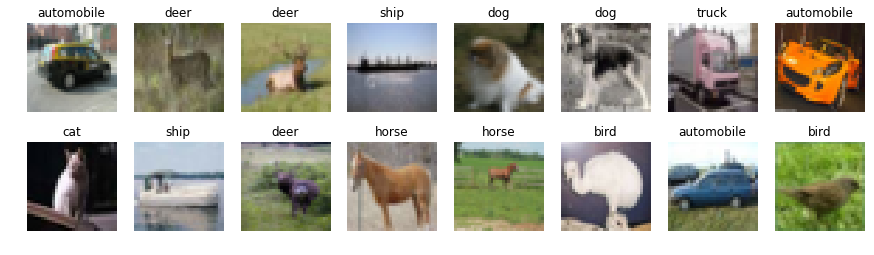

In [50]:

# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])

In [51]:
IMG_SHAPE = x_train.shape[1:]

# center images
x_train = x_train.astype('float32') / 255.0 - 0.5
x_test = x_test.astype('float32') / 255.0 - 0.5

In [52]:
x_train[0][0][0]

array([-0.26862746, -0.25686276, -0.2529412 ], dtype=float32)

In [53]:
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    
    # encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    
    encoder.add(Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
#     encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D(pool_size=(2, 2)))
#     encoder.add(Dropout(0.1))
    
    encoder.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
#     encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D(pool_size=(2, 2)))
#     encoder.add(Dropout(0.1))
    
    encoder.add(Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
#     encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D(pool_size=(2, 2)))
#     encoder.add(Dropout(0.1))
    
    encoder.add(Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D(pool_size=(2, 2)))
    encoder.add(Dropout(0.1))
    
    encoder.add(Flatten())                  #flatten image to vector
    
    encoder.add(Dense(1024, activation='elu'))
    encoder.add(Dense(1024, activation='elu'))

    
    encoder.add(Dense(code_size)) 

    # decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    
    decoder.add(Dense(2*2*256))  #actual decoder, height*width*3 units
    
    decoder.add(Dense(1024, activation='elu'))
    decoder.add(Dense(1024, activation='elu'))
    
    decoder.add(Reshape((2,2,256)))
    
    decoder.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    
    decoder.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    
    decoder.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    
    decoder.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder


In [54]:
# def build_deep_autoencoder(img_shape, code_size):
#     H,W,C = img_shape
    
#     # encoder
#     encoder = keras.models.Sequential()
#     encoder.add(L.InputLayer(img_shape))
    
#     encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
#     encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
# #     encoder.add(L.BatchNormalization())
    
#     encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
#     encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
# #     encoder.add(L.BatchNormalization())
    
#     encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
#     encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
# #     encoder.add(L.BatchNormalization())
    
# #     encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
# #     encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
# #     encoder.add(L.BatchNormalization())
    
#     encoder.add(L.Flatten())                  #flatten image to vector
    
#     encoder.add(L.Dense(2048, activation='elu'))
#     encoder.add(L.Dense(2048, activation='elu'))
# #     encoder.add(L.Dense(1024, activation='elu'))

# #     encoder.add(L.Dropout(rate=0.2))
# #     encoder.add(L.BatchNormalization())
    
# #     encoder.add(L.Dense(512, activation='elu'))
# #     encoder.add(L.Dropout(rate=0.2))
# #     encoder.add(L.BatchNormalization())

# #     encoder.add(L.Dense(256, activation='elu'))
    
# #     encoder.add(L.Dense(128, activation='elu'))
    
#     encoder.add(L.Dense(code_size)) 

#     # decoder
#     decoder = keras.models.Sequential()
#     decoder.add(L.InputLayer((code_size,)))
    
#     decoder.add(L.Dense(4*4*128))  #actual decoder, height*width*3 units
    
# #     decoder.add(L.Dense(128, activation='elu'))
# #     decoder.add(L.Dropout(rate=0.2))
# #     decoder.add(L.BatchNormalization())
    
# #     decoder.add(L.Dense(256, activation='elu'))
# #     decoder.add(L.Dropout(rate=0.2))
# #     decoder.add(L.BatchNormalization())
# #     decoder.add(L.Dense(512, activation='elu'))
    
#     decoder.add(L.Dense(2048, activation='elu'))
#     decoder.add(L.Dense(2048, activation='elu'))
# #     decoder.add(L.Dense(1024, activation='elu'))
    
#     decoder.add(L.Reshape((4,4,128)))
    
#     decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
# #     decoder.add(L.BatchNormalization())
    
#     decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
# #     decoder.add(L.BatchNormalization())
    
#     decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
# #     decoder.add(L.BatchNormalization())
    
# #     decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
#     return encoder, decoder


In [55]:
reset_tf_session()

In [56]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=bit_size)
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)         295168    
__________

In [57]:
def lr_scheduler(epoch):
    lrate = 0.001
    
    if epoch > 15:
        lrate = 0.0005
    if epoch > 20:
        lrate = 0.0003
    
    return lrate

In [58]:
optimizer = keras.optimizers.adam(decay=1e-6, amsgrad=True)

In [60]:
log_path = F'logs/autoencoder-{bit_size}-{architecture}-{autoencoder_id}'
tensorboard = TensorBoard(log_dir=log_path)

In [61]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [ ]:
batch_size = 100

gen = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True, width_shift_range=0.1, height_shift_range=0.1, zoom_range==0.1, rotation_range==10)

# Training

In [62]:
autoencoder.fit(x=x_train, y=x_train, epochs=25,
                validation_data=[x_test, x_test],
                callbacks=[ModelSaveCallback('conv-encoder-a'), tensorboard],
                verbose=1,
                initial_epoch= 0)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 18s 351us/step - loss: 0.0213 - val_loss: 0.0171
Model saved in conv-encoder-a
Epoch 2/25
50000/50000 [==============================] - 18s 352us/step - loss: 0.0164 - val_loss: 0.0151
Model saved in conv-encoder-a
Epoch 3/25
50000/50000 [==============================] - 18s 351us/step - loss: 0.0148 - val_loss: 0.0140
Model saved in conv-encoder-a
Epoch 4/25
50000/50000 [==============================] - 18s 354us/step - loss: 0.0137 - val_loss: 0.0131
Model saved in conv-encoder-a
Epoch 5/25
50000/50000 [==============================] - 18s 355us/step - loss: 0.0129 - val_loss: 0.0124
Model saved in conv-encoder-a
Epoch 6/25
50000/50000 [==============================] - 18s 363us/step - loss: 0.0122 - val_loss: 0.0119
Model saved in conv-encoder-a
Epoch 7/25
50000/50000 [==============================] - 17s 348us/step - loss: 0.0117 - val_loss: 0.0116
Model saved in conv-e

In [63]:

def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

In [64]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1), interpolation='spline16')

Convolutional autoencoder MSE: 0.008128341306746006


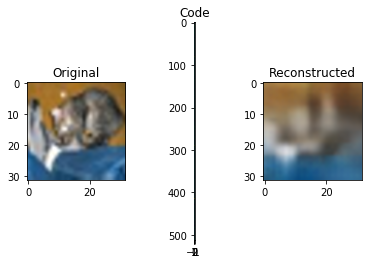

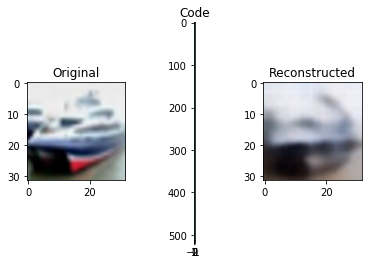

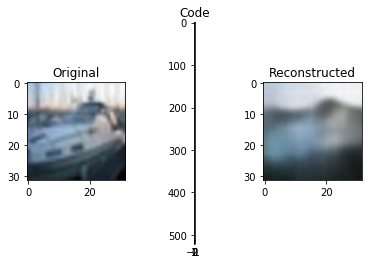

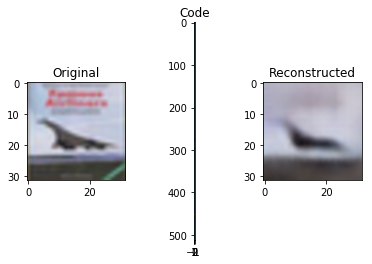

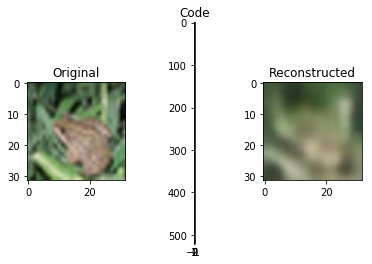

In [65]:
reconstruction_mse = autoencoder.evaluate(x_test, x_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = x_test[i]
    visualize(img,encoder,decoder)

In [67]:
autoencoder.save(F'{model_path}autoencoder{autoencoder_id}.h5')

In [68]:
encoder.save(F'{model_path}encoder{autoencoder_id}.h5')

In [69]:
decoder.save(F'{model_path}decoder{autoencoder_id}.h5')